In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
%run imports.py

In [3]:
task = mnist.MNIST()
task.load_all_data(device)

In [3]:
h, w = 32, 32
nph, npw = 8, 8
bs_train, bs_test = 500, 1000

transform = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize((0.4914, 0.4822, 0.4465), (0.247, 0.243, 0.261)),
#     torchvision.transforms.Resize((h, w), ), 
#     Rearrange('c (nph psh) (npw psw) -> (nph npw) (psh psw c)', nph=8, npw=8),
])
ds_train = torchvision.datasets.CIFAR10('~/datasets/cifar10/', train=True, download=True, transform=transform)
ds_test = torchvision.datasets.CIFAR10('~/datasets/cifar10/', train=False, download=True, transform=transform)
dl_train = torch.utils.data.DataLoader(ds_train, batch_size=bs_train, shuffle=True,)
dl_test = torch.utils.data.DataLoader(ds_test, batch_size=bs_test, shuffle=True,)
labels = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

Files already downloaded and verified
Files already downloaded and verified


In [4]:
import mlp_shaker_flat
import torchinfo

In [5]:
net = mlp_shaker_flat.ViShaker([8, 8, 4, 4, 3], [0, 1, 2, 3, 4]*30, 
                               global_avg_pool_str='b i j k l m-> b k l m')
# net = mlp_shaker_flat.ViShaker([64, 48], [0, 1]*16, 
#                                global_avg_pool_str='b i j -> b j')
torchinfo.summary(net, input_size=(bs_train, 3, 32, 32), device='cuda')

Layer (type:depth-idx)                   Output Shape              Param #
ViShaker                                 --                        --
├─Rearrange: 1-1                         [500, 8, 8, 4, 4, 3]      --
├─MLPFlatShaker: 1-2                     [500, 8, 8, 4, 4, 3]      --
│    └─ModuleList: 2                     --                        --
│    │    └─PreNormResidual: 3-1         [500, 8, 8, 4, 4, 3]      160
│    │    └─PreNormResidual: 3-2         [500, 8, 8, 4, 4, 3]      160
│    │    └─PreNormResidual: 3-3         [500, 8, 8, 4, 4, 3]      48
│    │    └─PreNormResidual: 3-4         [500, 8, 8, 4, 4, 3]      48
│    │    └─PreNormResidual: 3-5         [500, 8, 8, 4, 4, 3]      30
│    │    └─PreNormResidual: 3-6         [500, 8, 8, 4, 4, 3]      160
│    │    └─PreNormResidual: 3-7         [500, 8, 8, 4, 4, 3]      160
│    │    └─PreNormResidual: 3-8         [500, 8, 8, 4, 4, 3]      48
│    │    └─PreNormResidual: 3-9         [500, 8, 8, 4, 4, 3]      48
│    │    └

In [6]:
loss_fn = nn.NLLLoss()
def evaluate_model(net, dl=None, n_batches=-1, tqdm=tqdm, device=None, verbose=False):
    net = net.to(device)
    n_correct, total = 0, 0
    loss_total = 0
    n_examples = 0
    loop = enumerate(dl)
    if tqdm is not None:
        loop = tqdm(loop, leave=False, total=max(n_batches, len(dl)))
    for batch_idx, (X_batch, Y_batch) in loop:
        X_batch, Y_batch = X_batch.to(device), Y_batch.to(device)
        if batch_idx == n_batches:
            break
        with torch.no_grad():
            Y_batch_pred = net(X_batch)
        n_correct += (Y_batch_pred.argmax(dim=-1)==Y_batch).sum().item()
        loss = loss_fn(Y_batch_pred, Y_batch).item()
        loss_total += loss * len(X_batch)
        n_examples += len(X_batch)
        total += len(Y_batch)
    loss_total /= n_examples
    accuracy = n_correct/total*100.
    if verbose:
        print(f'Average Loss: {loss_total:.03f}, Accuracy: {accuracy:.03f}%')
    return {'loss': loss_total, 'accuracy': accuracy}
    
def train_classification_model(net, dl, n_epochs=10, device=None):
    net = net.to(device)
    opt = torch.optim.Adam(net.parameters(), lr=1e-3, )
    
    for epoch_idx in tqdm(range(n_epochs)):
        loop = enumerate(dl)
        if tqdm is not None:
            loop = tqdm(loop, leave=False, total=len(dl))
        for batch_idx, (X_batch, Y_batch) in loop:
            X_batch, Y_batch = X_batch.to(device), Y_batch.to(device)
            Y_batch_pred = net(X_batch)

            loss = loss_fn(Y_batch_pred, Y_batch)

            opt.zero_grad()
            loss.backward()
            opt.step()
        evaluate_model(net, dl_test, device='cuda', verbose=True)
    

# My MLP SHAKER implementation:

In [7]:
evaluate_model(net, dl_test, device='cuda', verbose=True)
train_classification_model(net, dl_train, n_epochs=30, device='cuda')
evaluate_model(net, dl_test, device='cuda', verbose=True)

Average Loss: 3.115, Accuracy: 11.480%


Average Loss: 2.136, Accuracy: 19.140%


Average Loss: 1.991, Accuracy: 24.700%


Average Loss: 1.891, Accuracy: 27.290%


Average Loss: 1.830, Accuracy: 29.990%


Average Loss: 1.771, Accuracy: 32.200%


Average Loss: 1.743, Accuracy: 32.980%


Average Loss: 1.728, Accuracy: 34.460%


Average Loss: 1.702, Accuracy: 35.570%


RuntimeError: CUDA error: an illegal memory access was encountered

# My MLP mixer implementation:

In [37]:
evaluate_model(net, dl_test, device='cuda', verbose=True)
train_classification_model(net, dl_train, n_epochs=30, device='cuda')
evaluate_model(net, dl_test, device='cuda', verbose=True)

Average Loss: 2.332, Accuracy: 12.790%


Average Loss: 1.495, Accuracy: 45.060%


Average Loss: 1.327, Accuracy: 52.160%


Average Loss: 1.228, Accuracy: 55.280%


Average Loss: 1.182, Accuracy: 56.240%


Average Loss: 1.144, Accuracy: 58.880%


Average Loss: 1.172, Accuracy: 58.430%


Average Loss: 1.158, Accuracy: 59.030%


Average Loss: 1.201, Accuracy: 58.810%


Exception ignored in: <generator object tqdm.__iter__ at 0x7f14e0699350>
Traceback (most recent call last):
  File "/home/akarshkumar0101/.local/lib/python3.7/site-packages/tqdm/std.py", line 1183, in __iter__
    self.close()
  File "/home/akarshkumar0101/.local/lib/python3.7/site-packages/tqdm/notebook.py", line 251, in close
    super(tqdm_notebook, self).close(*args, **kwargs)
  File "/home/akarshkumar0101/.local/lib/python3.7/site-packages/tqdm/std.py", line 1271, in close
    self._decr_instances(self)
  File "/home/akarshkumar0101/.local/lib/python3.7/site-packages/tqdm/std.py", line 572, in _decr_instances
    cls.monitor.exit()
  File "/home/akarshkumar0101/.local/lib/python3.7/site-packages/tqdm/_monitor.py", line 53, in exit
    self.join()
  File "/usr/lib/python3.7/threading.py", line 1044, in join
    self._wait_for_tstate_lock()
  File "/usr/lib/python3.7/threading.py", line 1060, in _wait_for_tstate_lock
    elif lock.acquire(block, timeout):
KeyboardInterrupt: 


RuntimeError: CUDA error: an illegal memory access was encountered

# other MLP mixer implementation:

In [31]:
evaluate_model(net, dl_test, device='cuda', verbose=True)
train_classification_model(net, dl_train, n_epochs=30, device='cuda')
evaluate_model(net, dl_test, device='cuda', verbose=True)

Average Loss: 2.321, Accuracy: 10.670%


Average Loss: 1.558, Accuracy: 43.110%


Average Loss: 1.394, Accuracy: 49.060%


Average Loss: 1.285, Accuracy: 54.020%


Average Loss: 1.238, Accuracy: 55.350%


Average Loss: 1.204, Accuracy: 56.900%


Average Loss: 1.168, Accuracy: 58.750%


Average Loss: 1.136, Accuracy: 59.740%


Average Loss: 1.121, Accuracy: 60.520%


Average Loss: 1.134, Accuracy: 60.240%


Average Loss: 1.125, Accuracy: 60.510%


Average Loss: 1.145, Accuracy: 60.970%


Average Loss: 1.182, Accuracy: 60.740%


Average Loss: 1.172, Accuracy: 61.200%


Average Loss: 1.218, Accuracy: 60.010%


Average Loss: 1.285, Accuracy: 59.700%


Exception ignored in: <generator object tqdm.__iter__ at 0x7f148dcbaed0>
Traceback (most recent call last):
  File "/home/akarshkumar0101/.local/lib/python3.7/site-packages/tqdm/std.py", line 1183, in __iter__
    self.close()
  File "/home/akarshkumar0101/.local/lib/python3.7/site-packages/tqdm/notebook.py", line 251, in close
    super(tqdm_notebook, self).close(*args, **kwargs)
  File "/home/akarshkumar0101/.local/lib/python3.7/site-packages/tqdm/std.py", line 1271, in close
    self._decr_instances(self)
  File "/home/akarshkumar0101/.local/lib/python3.7/site-packages/tqdm/std.py", line 572, in _decr_instances
    cls.monitor.exit()
  File "/home/akarshkumar0101/.local/lib/python3.7/site-packages/tqdm/_monitor.py", line 53, in exit
    self.join()
  File "/usr/lib/python3.7/threading.py", line 1044, in join
    self._wait_for_tstate_lock()
  File "/usr/lib/python3.7/threading.py", line 1060, in _wait_for_tstate_lock
    elif lock.acquire(block, timeout):
KeyboardInterrupt: 


KeyboardInterrupt: 

In [12]:
evaluate_model(net, dl_train, device='cuda', verbose=True)

Average Loss: 1.533, Accuracy: 43.722%


{'loss': 1.5325301897525787, 'accuracy': 43.722}

# TODO:

to figure out why MLP-shaker isn't generalizing at it gets more dimensions,
we need to figure out why MLP-shaker does nto perform as well as MLP-mixer.

this is the same as figuring out why MLP-mixing does not perform as well as FC network.

to do this, we can create high dimensional linear mapping X -> M -> Y.
we can then fit to it a 
- linear model
- mlp mixer
- mlp shaker,
- ...

and see performance drop
however we can also change the number of blocks in mlp mixer and mlp shaker and hopefully that will generalize better


In [29]:
import mlp_mixer_pytorch

In [30]:
net = mlp_mixer_pytorch.MLPMixer(image_size=32, channels=3, 
                                 patch_size=8, dim=48, depth=10, 
                                 num_classes=10)


torchinfo.summary(net, input_size=(99, 3, 32, 32))

Layer (type:depth-idx)                   Output Shape              Param #
Sequential                               --                        --
├─Rearrange: 1-1                         [99, 16, 192]             --
├─Linear: 1-2                            [99, 16, 48]              9,264
├─Sequential: 1-3                        [99, 16, 48]              --
│    └─PreNormResidual: 2-1              [99, 16, 48]              --
│    │    └─LayerNorm: 3-1               [99, 16, 48]              96
│    │    └─Sequential: 3-2              [99, 16, 48]              2,128
│    └─PreNormResidual: 2-2              [99, 16, 48]              --
│    │    └─LayerNorm: 3-3               [99, 16, 48]              96
│    │    └─Sequential: 3-4              [99, 16, 48]              18,672
├─Sequential: 1-4                        [99, 16, 48]              --
│    └─PreNormResidual: 2-3              [99, 16, 48]              --
│    │    └─LayerNorm: 3-5               [99, 16, 48]              96
│    

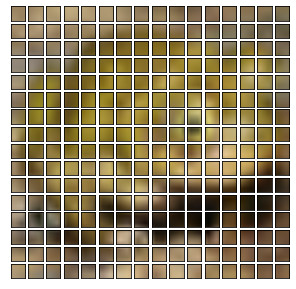

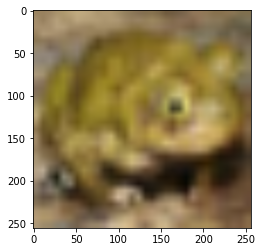

frog


In [107]:
def show_picture(X_batch, X_batch_patch, Y_batch, i=0):
    plt.figure(figsize=(5,5))
    for pi1 in range(16):
        for pi2 in range(16):
            plt.subplot(16, 16, pi1*16+pi2+1)
            plt.imshow(X_batch_patch[i, pi1, pi2].numpy())
            plt.xticks([]);plt.yticks([])
    plt.show()
    plt.imshow(X_batch[i].permute(1, 2, 0).numpy())
    plt.show()
    print(labels[Y_batch[i]])
    
show_picture(X_batch, X_batch_patch, Y_batch, 7)

In [193]:
net = mlp_shaker_flat.ViShaker([64, 48], [0, 1]*50, 
                               global_avg_pool_str='b i j -> b j', residual=True, normalize=True)


X = torch.randn(10, 3, 32, 32)
Y = torch.randint(high=10, size=(10,))

loss_fn = nn.NLLLoss()
opt = torch.optim.Adam(net.parameters())

opt.zero_grad()
Yp = net(X)
loss = loss_fn(Yp, Y)
loss.backward()


In [194]:
# torchinfo.summary(net)

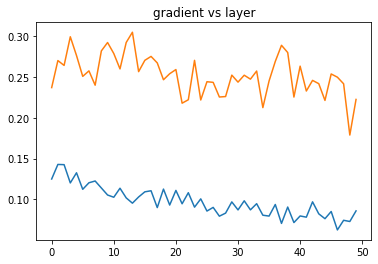

In [195]:
# grad_max = [p.grad.abs().max().item() for p in net.parameters()]
# grad_min = [p.grad.abs().min().item() for p in net.parameters()]
# grad_mean = [p.grad.abs().mean().item() for p in net.parameters()]


# grad_max = [net.shaker.mix_dims[i].fn[0].weight.grad.norm().max().item() for i in range(20)]
# grad_min = [net.shaker.mix_dims[i].fn[0].weight.grad.norm().min().item() for i in range(20)]
# grad_mean = [net.shaker.mix_dims[i].fn[0].weight.grad.norm().mean().item() for i in range(20)]

grad_norm = [net.shaker.mix_dims[i].fn[3].weight.grad.flatten().norm().item() for i in range(0, 100,2)]
plt.plot(grad_norm)
grad_norm = [net.shaker.mix_dims[i].fn[3].weight.grad.flatten().norm().item() for i in range(1, 100,2)]
plt.plot(grad_norm)
# plt.plot(grad_mean)
# plt.plot(grad_min)
plt.title('gradient vs layer')
plt.show()

In [206]:

# with contextlib.redirect_stdout(None):
net = MLPShakerBlock([[32, 8], [16, [4,2,2]]], [3, 2, 3])
#     net = MLPShakerBlock([256, 256], [3])
print('# parameters: ', count_params(net))
net(torch.randn(10, 256*256)).shape

Decomposing (depth=3) [[32, 8], [16, [4, 2, 2]]] -> [256, 256]
with repeats=[3, 2, 3]
----> 3x 
	Decomposing (depth=2) [32, 8] -> [32, 8]
	with repeats=[2, 3]
	----> 2x 
	Putting Linear size 32
	Putting Linear size 8
	<----
	Decomposing (depth=2) [16, [4, 2, 2]] -> [16, 16]
	with repeats=[2, 3]
	----> 2x 
	Putting Linear size 16
		Decomposing (depth=1) [4, 2, 2] -> [4, 2, 2]
		with repeats=[3]
		----> 3x 
		Putting Linear size 4
		Putting Linear size 2
		Putting Linear size 2
		<----
	<----
<----
# parameters:  8976
torch.Size([10, 65536]) --> torch.Size([10, 256, 256])
torch.Size([10, 256, 256]) --> torch.Size([2560, 32, 8])
Densely mixing with 32
Densely mixing with 8
Densely mixing with 32
Densely mixing with 8
torch.Size([10, 256, 256]) <-- torch.Size([2560, 32, 8])
torch.Size([10, 256, 256]) --> torch.Size([2560, 16, 16])
Densely mixing with 16
torch.Size([2560, 16, 16]) --> torch.Size([40960, 4, 2, 2])
Densely mixing with 4
Densely mixing with 2
Densely mixing with 2
Densely mixi

torch.Size([10, 65536])